In [1]:
# this block is used to define the system parameters and initialize the system at steady state. You are strongly discouraged 
#from changing anything in this block


# Imports

from math import pi, exp
from scipy.optimize import fsolve
import numpy
from steady_state_values import steady_state
from dynamic_simulation import differential_equations,states,algebraic_equations_kinetics,algebraic_equations_density,algebraic_equations_h,\
algebraic_equations_valve,algebraic_equations_section_height,algebraic_equations_heat_transfer, Cc_with_dead_time


from matplotlib import pyplot as plot
%matplotlib inline

In [27]:
# Parameters
Ko = 2.941e8  # m^3/(s*kmol)
Ea = 75360  # KJ/kmol
R = 8.313  # KJ/(kmol K)
rho_a = 801.2  # kg/m^3
rho_b = 966.2  # kg/m^3
rho_c = 1004   # kg/m^3
rho_solvent = 764.6  # kg/m^3
rhocw = 966.2  # kg/m^3 Water density
MM_A = 58.1  # kg/kmol
MM_B = 18  # kg/kmol
MM_C = 76.09  # kg/kmol

Cv1 = 3.089e-3  # m^2
alpha1 = 2
delta_Pv1 = 703.6  # Pa
delta_Pv3 = 100 #Pa
Cv2 = 1.33e-3  # m^2
Cv3 = (2.360e-3/(2**(-0.5)))/(numpy.sqrt(delta_Pv3/966.2))  #m^2
alpha2 = 2
alpha3 = 2
g = 9.807  # m/s^2
tau_v1 = 36
zeta_v1 = 0.35
Kv1 = 1/80  # 1/Kpa
Kv3 = 1/80   # 1/kpa
tau_v2 = 36
tau_v3 = 36
Kv2 = 1/80  # 1/Kpa

Cp1 = 2.522  # KJ/kg degC
Cp2 = 4.187  # KJ/kg degC
Cp3 = 2.531  # KJ/kg degC
Cpcw = 4.187  # BTU/lbm/degF

delta_H = -84660  # Kj/kmol A
Uj = 4.750  # kW/(m^2 degC)
D = 1  # m
U_air = 44.5/1000  # kW/(m^2 degC)
L = 1.5*D  # m
A = (pi/4)*(D**2)  # m^2
To = 21.1  # degC
theta = 5  # s
Vj = ((pi/4)*(D*1.1)**2 - A)*L/3  # m^3

In [82]:
################# EXOGENOUS INPUTS ###############################

# Disturbances

def Cao(t):               #Dist
    return 7.4  # kmol/m^3


def Tbo(t):               #Dist
    return 24  # degC


def F1(t):                #Dist
    return 7.334e-4  # m^3/s

# MV's

def Ps1(t):               
    return 60 +20

def Ps2(t):            
    return 60 

def Ps3(t):
    return 60 


# assumed constant
def Cbo(t):              #Const
    return 50     #kmol/m3

def Tcwo(t):
    return 29.4  # degc


def Tao(t):              #const
    return 24  # degC



In [83]:
########################### INITIALIZING THE SYSTEM AT STEADY STATE###################

# defining timespan and deadtime 
tspan = numpy.linspace(0, 2000, 1000)
dt = tspan[1]-tspan[0]
deadtime = 90

ss_values = steady_state()
ss_values['xv3'] = 0.5
ss_values['F_cw'] = 2.360e-3
# initial steady state values
ca = ss_values['Ca']
cb = ss_values['Cb']
cc = ss_values['Cc']
rho_1 = ss_values['rho1']
rho_2 = ss_values['rho2']
rho_3 = ss_values['rho3']
v = ss_values['V']
Q_j_tot = ss_values['Qj_tot']
Temp = ss_values['T']
Na = ss_values['Na']
F_2 = ss_values['F2']
F_3 = ss_values['F3']
F_cw = ss_values['F_cw']
Z = ss_values['z']
x_v1 = ss_values['xv1']
x_v2 = ss_values['xv2']
x_v3 = ss_values['xv3']
T_cw1 = ss_values['T_cw1']
T_cw2 = ss_values['T_cw2']
T_cw3 = ss_values['T_cw3']
Q_j1 = ss_values['Qj1']
Q_j2 = ss_values['Qj2']
Q_j3 = ss_values['Qj3']
Q_air1 = ss_values['Qair1']
Q_air2 = ss_values['Qair2']
Q_air3 = ss_values['Qair3']
dt = tspan[1] - tspan[0]
rao = ss_values['rao']
rbo = ss_values['rbo']
ra = ss_values['ra']
rb = ss_values['rb']
rc = ss_values['rc']
rsolvent = ss_values['rsolvent']
h_1 = ss_values['h1']
h_2 = ss_values['h2']
h_3 = ss_values['h3']
h = ss_values['H']
delta_Pv2 = ss_values['d_Pv2']
Cc_measured = cc


names = ['F2', 'F3','Fcw', 'Ca', 'Cb', 'Cc', 'Na', 'V', 'rho1', 'rho2', 'rho3', 'z', 'xv1', 'xv2','xv3', 'T', 'Qj_tot', 'T_cw1',
         'T_cw2', 'T_cw3', 'Qj1', 'Qj2', 'Qj3', 'Qair1', 'Qair2', 'Qair3', 'rao', 'rbo', 'ra', 'rb', 'rc',
         'rsolvent', 'h1', 'h2', 'h3', 'H', 'd_Pv2', 'Cc_measured']

# create the save dictionary

solution = {}

for key in names:
    solution[key] = []


# setting up the system for integration and solution storage

Cc_list = numpy.zeros_like(tspan)

 ############## LOOPING and euler integration ###########
    
for i, t in enumerate(tspan):         # we start at t1 not t0 because we have specified all the values to be at steady state at t0

    #system inputs (you may want to change one of these to be a controller output)

    f1 = F1(t)
    cao = Cao(t)
    cbo = Cbo(t)
    ps1 = Ps1(t)
    ps2 = Ps2(t)
    ps3 = Ps3(t)
    tao = Tao(t)
    tbo = Tbo(t)
    tcwo = Tcwo(t)
    
    ################# Updating solution dictionary ##############################################################

    sol = [F_2, F_3,F_cw, ca, cb, cc, Na, v, rho_1, rho_2, rho_3, Z, x_v1, x_v2,x_v3, Temp,  Q_j_tot, T_cw1, T_cw2, T_cw3,\
           Q_j1, Q_j2, Q_j3, Q_air1, Q_air2, Q_air3, rao, rbo, ra, rb, rc, rsolvent, h_1, h_2, h_3, h, delta_Pv2,Cc_measured]
    
    
    for j,name in enumerate(names):
        solution[name].append(sol[j])
    
        
    ################################ Add controller here ###################################################     
#     ccsp = Ccsp(t)   # controller set point 
#     error = ccsp - Cc_measured     


    
    
    
    ################################# SYSTEM DYNAMICS - DO NOT EDIT! ###########################################
    # here we calculate the differential and algebraic equations to get the next value for each variable, you are encouraged to read through and 
    # understand the mechanics of the loop but it is not necessary to edit this section.

    diff_eq_inputs = [f1, F_2, F_3,F_cw, cao, cbo, ca, cb, cc, Na, v, rho_1, rho_2, rho_3, Z, x_v1, x_v2,x_v3, ps1,
                      ps2,ps3, tao, tbo, Temp,
                      Q_j_tot, Q_j1, Q_j2, Q_j3, tcwo, T_cw1, T_cw2, T_cw3, Q_air1, Q_air2, Q_air3]

    # calculating differential states and integrating stepwise
    deltas = differential_equations(diff_eq_inputs)              # [ dVca_dt, dVCb_dt...]
    current_states = [v*ca, v*cb, v*cc, v*rho_3, Z, x_v1, x_v2, x_v3, rho_3*v*Temp, T_cw1, T_cw2, T_cw3]
    
    VCa, VCb, VCc, Vrho3, Z, x_v1, x_v2,x_v3, rho3VT, T_cw1, T_cw2, T_cw3 = [j + deltas[i]*dt for i,j in enumerate(current_states)]  # euler integration step
    
    states_inputs = [VCa, VCb, VCc, Vrho3, rho3VT]              # used to solve for states we are interested in
    states_old = [ca, cb, cc, v, rho_3, Temp]                   #initial guesses for fsolve

    # newly calculated state variables
    ca, cb, cc, v, rho_3, Temp = states(states_inputs, states_old)

    # list of the inputs to solve the kinetic parameters
    kinetics_inputs = [ca, cb, Temp]
    K, Na = algebraic_equations_kinetics(kinetics_inputs)

    # list of the inputs to solve the densities and mass fractions
    density_inputs = [cao, cbo, ca, cb, cc, rho_3]
    rao, rbo, rho_1, rho_2, ra, rb, rc, rsolvent = algebraic_equations_density(density_inputs)

    # calculate tank level
    h_inputs = [v]
    h, = algebraic_equations_h(h_inputs)

    # calculate flow through valves
    valve_inputs = [x_v1, x_v2, x_v3, rho_2, rho_3,rhocw, h]    # add density for water as input 
    F_2, F_3,F_cw, delta_Pv2 = algebraic_equations_valve(valve_inputs)

    # calculate the liquid height as experienced by each segment
    height_inputs = [h]
    h_1, h_2, h_3 = algebraic_equations_section_height(height_inputs)

    # calculate the heat transfer rates
    heat_transfer_inputs = [h_1, h_2, h_3, Temp, T_cw1, T_cw2, T_cw3]
    Q_j1, Q_j2, Q_j3, Q_air1, Q_air2, Q_air3, Q_j_tot= algebraic_equations_heat_transfer(heat_transfer_inputs)

    # calculate the measured C concentration
    Cc_list[i] = cc
    Cc_measured = Cc_with_dead_time(t, Cc_list, tspan,deadtime) 
    


After running the euler loop you should have a solution dictionary containing all the information needed to plot anything you want about the system. If you get errors it is recommended that you restart the python kernal and run every cell before asking the lecturer or TA for help. GOOD LUCK!

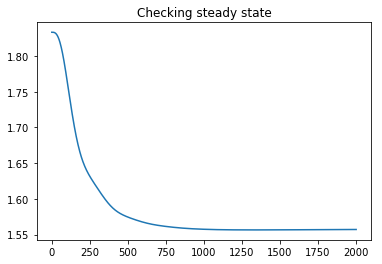

In [85]:
# Heres an example of how I would plot things. 
plot.figure()

plot.plot(tspan,solution['Cc'])
#plot.plot(tspan,solution["Cc_measured"])
plot.title("Checking steady state")


In [86]:
from scipy.signal import lti

def FOPDT(var,u,tspan,yo):
    
    kc,tau,theta = var
    G1 = lti([kc],[tau,1])
    dt = tspan[1]-tspan[0]
    results = numpy.zeros(len(tspan))
    yvals = numpy.zeros(len(tspan))
    y = yo
    x = numpy.zeros([G1.A.shape[0],1])
    
    for i,t in enumerate(tspan):
        yvals[i] = y
        t_interp = t - theta
        ydelayed = numpy.interp(t_interp, tspan,yvals) 
        results[i] = ydelayed
        dx = G1.A.dot(x) + G1.B.dot(u)
        x += dx*dt
        y_prime = G1.C.dot(x) +G1.D.dot(u)
        y = y_prime[0][0] + yo
        
    return numpy.array(results)
    

In [87]:
from scipy.optimize import minimize

In [88]:
def error_func(var,u,t,yo):
    kc,tau,theta = var
    results = FOPDT(var,u,t,yo)
    abs_error = abs(solution['Cc'] - results)
    err = sum(abs_error)
    return err

In [89]:
error_func([1,1,1],20,tspan,ss_values['Cc'])

20227.749096490083

In [102]:
def run_sim(stepvar):
    ################# EXOGENOUS INPUTS ###############################

    # Disturbances

    def Cao(t):  # Dist
        if stepvar == 'Cao':
            return 7.4 + 0.2*7.4  # kmol/m^3
        else:
            return 7.4

    def Tbo(t):  # Dist
        if stepvar == 'Tbo':
            return 24 + 0.2*24
        else:
            return 24  # degC

    def F1(t):  # Dist
        if stepvar == 'F1':
            return 7.334e-4 + 0.2*7.334e-4
        else:
            return 7.334e-4  # m^3/s

    # MV's

    def Ps1(t):
        if stepvar == 'Ps1':
            return 60 + 20
        else:
            return 60

    def Ps2(t):
        if stepvar == 'Ps2':
            return 60+20
        else:
            return 60

    def Ps3(t):
        if stepvar == 'Ps3':

            return 60 +20
        else:
            return 60
    # assumed constant
    def Cbo(t):  # Const
        return 50  # kmol/m3

    def Tcwo(t):
        return 29.4  # degc

    def Tao(t):  # const
        return 24  # degC

    ########################### INITIALIZING THE SYSTEM AT STEADY STATE###################

    # defining timespan and deadtime 
    tspan = numpy.linspace(0, 2000, 1000)
    dt = tspan[1]-tspan[0]
    deadtime = 90

    ss_values = steady_state()
    ss_values['xv3'] = 0.5
    ss_values['F_cw'] = 2.360e-3
    # initial steady state values
    ca = ss_values['Ca']
    cb = ss_values['Cb']
    cc = ss_values['Cc']
    rho_1 = ss_values['rho1']
    rho_2 = ss_values['rho2']
    rho_3 = ss_values['rho3']
    v = ss_values['V']
    Q_j_tot = ss_values['Qj_tot']
    Temp = ss_values['T']
    Na = ss_values['Na']
    F_2 = ss_values['F2']
    F_3 = ss_values['F3']
    F_cw = ss_values['F_cw']
    Z = ss_values['z']
    x_v1 = ss_values['xv1']
    x_v2 = ss_values['xv2']
    x_v3 = ss_values['xv3']
    T_cw1 = ss_values['T_cw1']
    T_cw2 = ss_values['T_cw2']
    T_cw3 = ss_values['T_cw3']
    Q_j1 = ss_values['Qj1']
    Q_j2 = ss_values['Qj2']
    Q_j3 = ss_values['Qj3']
    Q_air1 = ss_values['Qair1']
    Q_air2 = ss_values['Qair2']
    Q_air3 = ss_values['Qair3']
    dt = tspan[1] - tspan[0]
    rao = ss_values['rao']
    rbo = ss_values['rbo']
    ra = ss_values['ra']
    rb = ss_values['rb']
    rc = ss_values['rc']
    rsolvent = ss_values['rsolvent']
    h_1 = ss_values['h1']
    h_2 = ss_values['h2']
    h_3 = ss_values['h3']
    h = ss_values['H']
    delta_Pv2 = ss_values['d_Pv2']
    Cc_measured = cc


    names = ['F2', 'F3','Fcw', 'Ca', 'Cb', 'Cc', 'Na', 'V', 'rho1', 'rho2', 'rho3', 'z', 'xv1', 'xv2','xv3', 'T', 'Qj_tot', 'T_cw1',
         'T_cw2', 'T_cw3', 'Qj1', 'Qj2', 'Qj3', 'Qair1', 'Qair2', 'Qair3', 'rao', 'rbo', 'ra', 'rb', 'rc',
         'rsolvent', 'h1', 'h2', 'h3', 'H', 'd_Pv2', 'Cc_measured']

    # create the save dictionary

    solution = {}

    for key in names:
        solution[key] = []


    # setting up the system for integration and solution storage

    Cc_list = numpy.zeros_like(tspan)

    ############## LOOPING and euler integration ###########

    for i, t in enumerate(tspan):         # we start at t1 not t0 because we have specified all the values to be at steady state at t0

        #system inputs (you may want to change one of these to be a controller output)

        f1 = F1(t)
        cao = Cao(t)
        cbo = Cbo(t)
        ps1 = Ps1(t)
        ps2 = Ps2(t)
        ps3 = Ps3(t)
        tao = Tao(t)
        tbo = Tbo(t)
        tcwo = Tcwo(t)

        ################# Updating solution dictionary ##############################################################

        sol = [F_2, F_3,F_cw, ca, cb, cc, Na, v, rho_1, rho_2, rho_3, Z, x_v1, x_v2,x_v3, Temp,  Q_j_tot, T_cw1, T_cw2, T_cw3,\
               Q_j1, Q_j2, Q_j3, Q_air1, Q_air2, Q_air3, rao, rbo, ra, rb, rc, rsolvent, h_1, h_2, h_3, h, delta_Pv2,Cc_measured]


        for j,name in enumerate(names):
            solution[name].append(sol[j])


        ################################ Add controller here ###################################################     
        #     ccsp = Ccsp(t)   # controller set point 
        #     error = ccsp - Cc_measured     





        ################################# SYSTEM DYNAMICS - DO NOT EDIT! ###########################################
        # here we calculate the differential and algebraic equations to get the next value for each variable, you are encouraged to read through and 
        # understand the mechanics of the loop but it is not necessary to edit this section.

        diff_eq_inputs = [f1, F_2, F_3,F_cw, cao, cbo, ca, cb, cc, Na, v, rho_1, rho_2, rho_3, Z, x_v1, x_v2,x_v3, ps1,
                          ps2,ps3, tao, tbo, Temp,
                          Q_j_tot, Q_j1, Q_j2, Q_j3, tcwo, T_cw1, T_cw2, T_cw3, Q_air1, Q_air2, Q_air3]

        # calculating differential states and integrating stepwise
        deltas = differential_equations(diff_eq_inputs)              # [ dVca_dt, dVCb_dt...]
        current_states = [v*ca, v*cb, v*cc, v*rho_3, Z, x_v1, x_v2, x_v3, rho_3*v*Temp, T_cw1, T_cw2, T_cw3]

        VCa, VCb, VCc, Vrho3, Z, x_v1, x_v2,x_v3, rho3VT, T_cw1, T_cw2, T_cw3 = [j + deltas[i]*dt for i,j in enumerate(current_states)]  # euler integration step

        states_inputs = [VCa, VCb, VCc, Vrho3, rho3VT]              # used to solve for states we are interested in
        states_old = [ca, cb, cc, v, rho_3, Temp]                   #initial guesses for fsolve

        # newly calculated state variables
        ca, cb, cc, v, rho_3, Temp = states(states_inputs, states_old)

        # list of the inputs to solve the kinetic parameters
        kinetics_inputs = [ca, cb, Temp]
        K, Na = algebraic_equations_kinetics(kinetics_inputs)

        # list of the inputs to solve the densities and mass fractions
        density_inputs = [cao, cbo, ca, cb, cc, rho_3]
        rao, rbo, rho_1, rho_2, ra, rb, rc, rsolvent = algebraic_equations_density(density_inputs)

        # calculate tank level
        h_inputs = [v]
        h, = algebraic_equations_h(h_inputs)

        # calculate flow through valves
        valve_inputs = [x_v1, x_v2, x_v3, rho_2, rho_3,rhocw, h]    # add density for water as input 
        F_2, F_3,F_cw, delta_Pv2 = algebraic_equations_valve(valve_inputs)

        # calculate the liquid height as experienced by each segment
        height_inputs = [h]
        h_1, h_2, h_3 = algebraic_equations_section_height(height_inputs)

        # calculate the heat transfer rates
        heat_transfer_inputs = [h_1, h_2, h_3, Temp, T_cw1, T_cw2, T_cw3]
        Q_j1, Q_j2, Q_j3, Q_air1, Q_air2, Q_air3, Q_j_tot= algebraic_equations_heat_transfer(heat_transfer_inputs)

        # calculate the measured C concentration
        Cc_list[i] = cc
        Cc_measured = Cc_with_dead_time(t, Cc_list, tspan,deadtime) 

    
    return solution


In [123]:
ans = scipy.optimize.minimize(error_func,[0.1,100,30],args=(20,tspan,ss_values["Cc"]),tol = 2)

KeyboardInterrupt: 

In [120]:
ans.fun

1.1716496810695827

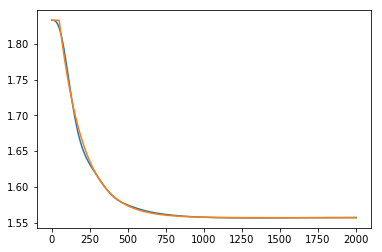

In [100]:
plot.plot(tspan,solution["Cc"])
plot.plot(tspan,FOPDT(ans.x,20,tspan,ss_values['Cc']))

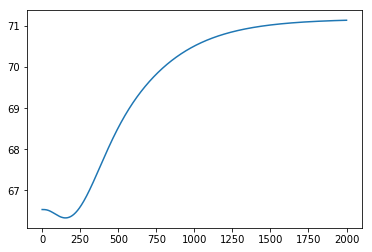

In [105]:
plot.plot(tspan,run_sim('Ps2')['T'])

In [112]:
sum(numpy.array([1,2,3]) - numpy.array([1,2,1]))

2

In [116]:
numpy.zeros([2,2])

array([[ 0.,  0.],
       [ 0.,  0.]])

In [122]:
scipy.optimize.minimize?